## Final notebook with final function1 and model performance check function2

## model deployed in heroku

https://healthcare-prediction.herokuapp.com/

In [1]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use(u'nbAgg')
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore") 
import seaborn as sns
from collections import Counter 
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve, f1_score, confusion_matrix
from prettytable import PrettyTable
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import joblib
from tqdm import tqdm

In [2]:
X = ['Test_Inpatientdata.csv',
     'Test_Outpatientdata.csv',
     'Test_Beneficiarydata.csv',
     'Test.csv']

In [22]:
test_inpatient = pd.read_csv('Test_Inpatientdata.csv')
test_outpatient = pd.read_csv('Test_Outpatientdata.csv') 
test_bene = pd.read_csv('Test_Beneficiarydata.csv')
test_data = pd.read_csv('Test.csv')

In [11]:
def final(X):
    """ function take raw input and then preprocess,featurize and trained """
    test_inpatient = X[0]
    test_outpatient = X[1]
    test_bene = X[2]
    test_data = X[3]
        
    inpatient = pd.read_csv(test_inpatient)
    outpatient = pd.read_csv(test_outpatient)
    beneficiary = pd.read_csv(test_bene)
    test = pd.read_csv(test_data)
    
    final_data = pd.merge(inpatient, outpatient, left_on = [ col for col in outpatient.columns if col in inpatient.columns], \
                    right_on = [ col for col in outpatient.columns if col in inpatient.columns], how = 'outer')
    
    final_data = pd.merge(final_data,beneficiary,how='inner',on='BeneID' )
    final_data = pd.merge(final_data,test,how='outer',on='Provider')
    print('all file merged...')
    
    ## pre processing
    ## removing ClmProcedureCode_5, ClmProcedureCode_6 as it has all null 

    final_data.drop('ClmProcedureCode_5',axis=1,inplace=True)
    final_data.drop('ClmProcedureCode_6',axis=1,inplace=True)

    ## remove as it has all value as same

    final_data.drop('NoOfMonths_PartACov',axis=1,inplace=True)
    final_data.drop('NoOfMonths_PartBCov',axis=1,inplace=True)
    
    ## replacing null with 0

    colFillna = ['ClmDiagnosisCode_1','ClmDiagnosisCode_2',
             'ClmDiagnosisCode_3','ClmDiagnosisCode_4',
             'ClmDiagnosisCode_5','ClmDiagnosisCode_6',
             'ClmDiagnosisCode_7','ClmDiagnosisCode_8',
             'ClmDiagnosisCode_9','ClmDiagnosisCode_10',
             'ClmProcedureCode_1','ClmProcedureCode_2',
             'ClmProcedureCode_3','ClmProcedureCode_4',
             'DiagnosisGroupCode','ClmAdmitDiagnosisCode','DeductibleAmtPaid']

    ## RenalDiseaseIndicator has y and 0 - replacing with 1 and 0
    final_data[colFillna]= final_data[colFillna].replace({np.nan:0})
    
    ## ChronicCond has 2 and 1 - replacing with 0 and 1
    final_data['RenalDiseaseIndicator'] = final_data['RenalDiseaseIndicator'].map({'Y':1,'0':0})
    final_data['ChronicCond_Alzheimer'] = final_data['ChronicCond_Alzheimer'].map({2:0,1:1})
    final_data['ChronicCond_Heartfailure'] = final_data['ChronicCond_Heartfailure'].map({2:0,1:1})
    final_data['ChronicCond_KidneyDisease'] = final_data['ChronicCond_KidneyDisease'].map({2:0,1:1})
    final_data['ChronicCond_Cancer'] = final_data['ChronicCond_Cancer'].map({2:0,1:1})
    final_data['ChronicCond_ObstrPulmonary'] = final_data['ChronicCond_ObstrPulmonary'].map({2:0,1:1})
    final_data['ChronicCond_Depression'] = final_data['ChronicCond_Depression'].map({2:0,1:1})
    final_data['ChronicCond_Diabetes'] = final_data['ChronicCond_Diabetes'].map({2:0,1:1})
    final_data['ChronicCond_IschemicHeart'] = final_data['ChronicCond_IschemicHeart'].map({2:0,1:1})
    final_data['ChronicCond_Osteoporasis'] = final_data['ChronicCond_Osteoporasis'].map({2:0,1:1})
    final_data['ChronicCond_rheumatoidarthritis'] = final_data['ChronicCond_rheumatoidarthritis'].map({2:0,1:1})
    final_data['ChronicCond_stroke'] = final_data['ChronicCond_stroke'].map({2:0,1:1})
    final_data['Gender'] = final_data['Gender'].map({2:0,1:1})
    print('data preprocessing done...')
    
    ## featurization
    
    ## counting num of times patient made claim
    bene_count = final_data['BeneID'].value_counts().to_dict()
    final_data['BeneCount'] = final_data['BeneID'].map(bene_count)
    
    ## counting num of times provider covered claim
    pro_count = final_data['Provider'].value_counts().to_dict()
    final_data['ProviderCount'] = final_data['Provider'].map(pro_count)
    
    ## counting num of times physician attended all patient
    attphy_count = final_data['AttendingPhysician'].value_counts().to_dict()
    final_data['AttendingPhysicianCount'] = final_data['AttendingPhysician'].map(attphy_count)
    ## replacing null with 0
    final_data['AttendingPhysicianCount'] = final_data['AttendingPhysicianCount'].fillna(0)
    
    ## num of days patient admitted
    
    ## converting non-null object type of dt column to datetime
    final_data['AdmissionDt']= pd.to_datetime(final_data['AdmissionDt'])
    final_data['DischargeDt']= pd.to_datetime(final_data['DischargeDt'])
    final_data['ClaimStartDt']= pd.to_datetime(final_data['ClaimStartDt'])
    final_data['ClaimEndDt']= pd.to_datetime(final_data['ClaimEndDt'])

    final_data['numOfDaysAdmitted'] = final_data['DischargeDt'] - final_data['AdmissionDt']
    ## filling na with 0 
    final_data['numOfDaysAdmitted'] = final_data['numOfDaysAdmitted'].fillna(0)
    ## converting days type to int
    final_data['numOfDaysAdmitted'] = final_data['numOfDaysAdmitted'].dt.days.astype('int64')
    
    ## num of days for claim took to reimbursed
    
    final_data['numOfDaysForClaim'] = final_data['ClaimEndDt'] - final_data['ClaimStartDt']
    ## filling na with 0 
    final_data['numOfDaysForClaim'] = final_data['numOfDaysForClaim'].fillna(0)
    ## converting days type to int
    final_data['numOfDaysForClaim'] = final_data['numOfDaysForClaim'].dt.days.astype('int64')
    
    ## calculating total ip,op amount reimburse
    
    ## adding ip op amount
    ip_op_total_amount = final_data['IPAnnualReimbursementAmt'] + final_data['OPAnnualReimbursementAmt']
    ## adding deductible amount
    ip_op_ded_amount = final_data['IPAnnualDeductibleAmt'] + final_data['OPAnnualDeductibleAmt']
    ## total amount - deductible amount
    ip_op_total_amount = ip_op_total_amount - ip_op_ded_amount
    final_data['ip_op_total_amount'] = ip_op_total_amount
    
    ## calculating total disease patient was diagnosed before
    
    num_of_chronic = final_data['RenalDiseaseIndicator'] + final_data['ChronicCond_Alzheimer'] + \
                    final_data['ChronicCond_Heartfailure'] + final_data['ChronicCond_KidneyDisease'] + \
                    final_data['ChronicCond_Cancer'] + final_data['ChronicCond_ObstrPulmonary'] + \
                    final_data['ChronicCond_Depression'] + final_data['ChronicCond_Diabetes'] + \
                    final_data['ChronicCond_IschemicHeart'] + final_data['ChronicCond_Osteoporasis'] + \
                    final_data['ChronicCond_rheumatoidarthritis'] + final_data['ChronicCond_stroke'] 
    final_data['num_of_chronic'] = num_of_chronic
    
    ## calculating num of diagnosis procedure undergonw by patient
    
    num_of_diag_proc = final_data[['ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 
       'DiagnosisGroupCode','ClmAdmitDiagnosisCode']].values
    
    ## counting non zero value in each row
    countnum_of_diag_proc = []
    for i in range(len(num_of_diag_proc)):
        countnum_of_diag_proc.append(np.count_nonzero(num_of_diag_proc[i]))
    final_data['num_of_diag_proc'] = countnum_of_diag_proc
    
    ## calculating num of physician treating patient
    
    num_of_phy = final_data[['AttendingPhysician','OperatingPhysician','OtherPhysician']].fillna(0).values
    countnum_of_phy = []
    for i in range(len(num_of_phy)):
        countnum_of_phy.append(np.count_nonzero(num_of_phy[i]))
        
    final_data['num_of_phy'] = countnum_of_phy
    
    ## one hot encoding diagnosis code
    
    top10 = ['4019','25000','2724','V5869','4011','42731','V5861','2720','2449','4280']
    for col in top10:
        final_data['diagnosis_'+str(col)] = np.where(final_data['ClmDiagnosisCode_1']==col,1,0)
        final_data['diagnosis_'+str(col)] = np.where(final_data['ClmDiagnosisCode_2']==col,1,\
                                       np.where(final_data['diagnosis_'+str(col)]==1,1,0 ))
        final_data['diagnosis_'+str(col)] = np.where(final_data['ClmDiagnosisCode_3']==col,1,\
                                       np.where(final_data['diagnosis_'+str(col)]==1,1,0 ))
        final_data['diagnosis_'+str(col)] = np.where(final_data['ClmDiagnosisCode_4']==col,1,\
                                       np.where(final_data['diagnosis_'+str(col)]==1,1,0 ))
        final_data['diagnosis_'+str(col)] = np.where(final_data['ClmDiagnosisCode_5']==col,1,\
                                       np.where(final_data['diagnosis_'+str(col)]==1,1,0 ))
        final_data['diagnosis_'+str(col)] = np.where(final_data['ClmDiagnosisCode_6']==col,1,\
                                       np.where(final_data['diagnosis_'+str(col)]==1,1,0 ))
        final_data['diagnosis_'+str(col)] = np.where(final_data['ClmDiagnosisCode_7']==col,1,\
                                       np.where(final_data['diagnosis_'+str(col)]==1,1,0 ))
        final_data['diagnosis_'+str(col)] = np.where(final_data['ClmDiagnosisCode_8']==col,1,\
                                       np.where(final_data['diagnosis_'+str(col)]==1,1,0 ))
        final_data['diagnosis_'+str(col)] = np.where(final_data['ClmDiagnosisCode_9']==col,1,\
                                       np.where(final_data['diagnosis_'+str(col)]==1,1,0 ))
        final_data['diagnosis_'+str(col)] = np.where(final_data['ClmDiagnosisCode_10']==col,1,\
                                       np.where(final_data['diagnosis_'+str(col)]==1,1,0 ))
        final_data['diagnosis_'+str(col)] = np.where(final_data['DiagnosisGroupCode']==col,1,\
                                       np.where(final_data['diagnosis_'+str(col)]==1,1,0 ))
        final_data['diagnosis_'+str(col)] = np.where(final_data['ClmAdmitDiagnosisCode']==col,1,\
                                       np.where(final_data['diagnosis_'+str(col)]==1,1,0 ))
        
    ## one hot encoding procedure code
        
    top5 = [4019.0, 9904.0, 2724.0, 8154.0, 66.0]
    for col in top5:
        final_data['procedure_'+str(col)] = np.where(final_data['ClmProcedureCode_1']==col,1,0)
        final_data['procedure_'+str(col)] = np.where(final_data['ClmProcedureCode_2']==col,1,\
                                       np.where(final_data['procedure_'+str(col)]==1,1,0 ))
        final_data['procedure_'+str(col)] = np.where(final_data['ClmProcedureCode_3']==col,1,\
                                       np.where(final_data['procedure_'+str(col)]==1,1,0 ))
        final_data['procedure_'+str(col)] = np.where(final_data['ClmProcedureCode_4']==col,1,\
                                       np.where(final_data['procedure_'+str(col)]==1,1,0 ))
            
    ## frequency encoding diagnosis, procedure code
        
    DiagnosisCode_1_count = final_data['ClmDiagnosisCode_1'].value_counts().to_dict()
    DiagnosisCode_1_count[0]=0
    DiagnosisCode_2_count = final_data['ClmDiagnosisCode_2'].value_counts().to_dict()
    DiagnosisCode_2_count[0]=0
    DiagnosisCode_3_count = final_data['ClmDiagnosisCode_3'].value_counts().to_dict()
    DiagnosisCode_3_count[0]=0
    DiagnosisCode_4_count = final_data['ClmDiagnosisCode_4'].value_counts().to_dict()
    DiagnosisCode_4_count[0]=0
    DiagnosisCode_5_count = final_data['ClmDiagnosisCode_5'].value_counts().to_dict()
    DiagnosisCode_5_count[0]=0
    DiagnosisCode_6_count = final_data['ClmDiagnosisCode_6'].value_counts().to_dict()
    DiagnosisCode_6_count[0]=0
    DiagnosisCode_7_count = final_data['ClmDiagnosisCode_7'].value_counts().to_dict()
    DiagnosisCode_7_count[0]=0
    DiagnosisCode_8_count = final_data['ClmDiagnosisCode_8'].value_counts().to_dict()
    DiagnosisCode_8_count[0]=0
    DiagnosisCode_9_count = final_data['ClmDiagnosisCode_9'].value_counts().to_dict()
    DiagnosisCode_9_count[0]=0
    DiagnosisCode_10_count = final_data['ClmDiagnosisCode_10'].value_counts().to_dict()
    DiagnosisCode_10_count[0]=0
    ClmAdmitDiagnosisCode_count = final_data['ClmAdmitDiagnosisCode'].value_counts().to_dict()
    ClmAdmitDiagnosisCode_count[0]=0
    DiagnosisGroupCode_count = final_data['DiagnosisGroupCode'].value_counts().to_dict()
    DiagnosisGroupCode_count[0]=0
    
    final_data['DiagnosisCode_1_count'] = final_data['ClmDiagnosisCode_1'].map(DiagnosisCode_1_count)
    final_data['DiagnosisCode_2_count'] = final_data['ClmDiagnosisCode_2'].map(DiagnosisCode_2_count)
    final_data['DiagnosisCode_3_count'] = final_data['ClmDiagnosisCode_3'].map(DiagnosisCode_3_count)
    final_data['DiagnosisCode_4_count'] = final_data['ClmDiagnosisCode_4'].map(DiagnosisCode_4_count)
    final_data['DiagnosisCode_5_count'] = final_data['ClmDiagnosisCode_5'].map(DiagnosisCode_5_count)
    final_data['DiagnosisCode_6_count'] = final_data['ClmDiagnosisCode_6'].map(DiagnosisCode_6_count)
    final_data['DiagnosisCode_7_count'] = final_data['ClmDiagnosisCode_7'].map(DiagnosisCode_7_count)
    final_data['DiagnosisCode_8_count'] = final_data['ClmDiagnosisCode_8'].map(DiagnosisCode_8_count)
    final_data['DiagnosisCode_9_count'] = final_data['ClmDiagnosisCode_9'].map(DiagnosisCode_9_count)
    final_data['DiagnosisCode_10_count'] = final_data['ClmDiagnosisCode_10'].map(DiagnosisCode_10_count)
    final_data['ClmAdmitDiagnosisCode_count'] = final_data['ClmAdmitDiagnosisCode'].map(ClmAdmitDiagnosisCode_count)
    final_data['DiagnosisGroupCode_count'] = final_data['DiagnosisGroupCode'].map(DiagnosisGroupCode_count)
    print('featurization done...')
    
    ## dropping col after featurization
    
    provider = final_data['Provider'].values

    final_data = final_data.drop(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider','AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt','ClmAdmitDiagnosisCode','DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4','DOB', 'DOD'],axis=1)
    
    final_data.to_csv('final_test_data_feature.csv')
    
    ## normalizing using min max scalar
    
    min_max_scaler = preprocessing.MinMaxScaler()
    def min_max(data,column):
        """ scaling column value using min max scalar, fitting on train and transforming """
        min_max_scaler.fit(data[column].values.reshape(-1,1))
        data_scale = min_max_scaler.transform(data[column].values.reshape(-1,1))
        return data_scale
    
    ## col to normalize
    col_to_nor = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'Race',
           'State', 'County', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
           'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'BeneCount',
           'ProviderCount', 'AttendingPhysicianCount', 'numOfDaysAdmitted',
           'numOfDaysForClaim', 'ip_op_total_amount', 'num_of_chronic',
           'num_of_diag_proc', 'num_of_phy', 'DiagnosisCode_1_count', 'DiagnosisCode_2_count',
           'DiagnosisCode_3_count', 'DiagnosisCode_4_count',
           'DiagnosisCode_5_count', 'DiagnosisCode_6_count',
           'DiagnosisCode_7_count', 'DiagnosisCode_8_count',
           'DiagnosisCode_9_count', 'DiagnosisCode_10_count',
           'ClmAdmitDiagnosisCode_count', 'DiagnosisGroupCode_count']
    for i in col_to_nor:
        data_scale = min_max(final_data,i)
        final_data[i] = data_scale
    print('normalizing done...')
    
    ## loading model
    
    def predict_using_best_threshold(probability, threshold):
        """ convert proba value using best threshold """
        predictions = []
        for i in probability:
            if i>=threshold:
                predictions.append(1)
            else:
                predictions.append(0)
        return predictions

    model = joblib.load('xgb_tuned_on_0.pkl')
    print('loading model done...')
    
    y_pred = model.predict_proba(final_data)[:,1]
    pred_on_best_threshold = predict_using_best_threshold(y_pred, threshold = 0.2092)
    
    prediction = pd.DataFrame()
    prediction['providerID'] = provider
    prediction['predictions'] = pred_on_best_threshold
    print('prediction done...')
    
    return prediction

In [12]:
prediction_on_test= final(X)
print(prediction_on_test)

all file merged...
data preprocessing done...
featurization done...
normalizing done...
loading model done...
prediction done...
       providerID  predictions
0        PRV57070            0
1        PRV57070            1
2        PRV57070            0
3        PRV57070            1
4        PRV57070            1
5        PRV57070            1
6        PRV57070            1
7        PRV57070            1
8        PRV57070            1
9        PRV57070            0
10       PRV57070            1
11       PRV57070            1
12       PRV56558            1
13       PRV56558            1
14       PRV56558            1
15       PRV56558            1
16       PRV56558            1
17       PRV56558            1
18       PRV56558            1
19       PRV56558            1
20       PRV56558            1
21       PRV56558            1
22       PRV56558            1
23       PRV56558            1
24       PRV56558            1
25       PRV56558            1
26       PRV56558            1
27 

In [14]:
## file with null filled with 0

final_data_test = pd.read_csv('final_data_feature.csv')
final_data_test.drop('Unnamed: 0',axis=1,inplace=True)

In [15]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(final_data_test, test_size=0.20,random_state=0)


In [17]:
Y = test['PotentialFraud']
X = test.drop('PotentialFraud', axis=1)

In [19]:
X.shape

(111643, 58)

In [23]:
def performance(X,Y):
    """ take input test and predict on trained model and check model performance"""
    
    ## normalizing using min max scalar
    
    min_max_scaler = preprocessing.MinMaxScaler()
    def min_max(data,column):
        """ scaling column value using min max scalar, fitting on train and transforming """
        min_max_scaler.fit(data[column].values.reshape(-1,1))
        data_scale = min_max_scaler.transform(data[column].values.reshape(-1,1))
        return data_scale
    
    ## col to normalize
    col_to_nor = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'Race',
           'State', 'County', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
           'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'BeneCount',
           'ProviderCount', 'AttendingPhysicianCount', 'numOfDaysAdmitted',
           'numOfDaysForClaim', 'ip_op_total_amount', 'num_of_chronic',
           'num_of_diag_proc', 'num_of_phy', 'DiagnosisCode_1_count', 'DiagnosisCode_2_count',
           'DiagnosisCode_3_count', 'DiagnosisCode_4_count',
           'DiagnosisCode_5_count', 'DiagnosisCode_6_count',
           'DiagnosisCode_7_count', 'DiagnosisCode_8_count',
           'DiagnosisCode_9_count', 'DiagnosisCode_10_count',
           'ClmAdmitDiagnosisCode_count', 'DiagnosisGroupCode_count']
    for i in col_to_nor:
        data_scale = min_max(X,i)
        X[i] = data_scale
    
     ## loading model
    
    def predict_using_best_threshold(probability, threshold):
        """ convert proba value using best threshold """
        predictions = []
        for i in probability:
            if i>=threshold:
                predictions.append(1)
            else:
                predictions.append(0)
        return predictions
    
    def plot_confusion_matrix(model,X,Y,threshold):
        """ ploting confusion matrix using best threshold """
        ## fpr,tpr,threshold
        y_pred = model.predict_proba(X)[:,1]
        fpr,tpr,thresholds = roc_curve(Y, y_pred)
    
        ## confusion matrix
        test_conmat = confusion_matrix(Y, predict_using_best_threshold(y_pred, threshold))

        sns.heatmap(test_conmat,xticklabels=['Predicted No','Predicted Yes'],yticklabels=['Actual No','Actual Yes'],annot=True,fmt='d')
        plt.title('confusion matrix on test')
        plt.show()

    def f1(model,X,Y,threshold):
        """ calculate f1, macro f1 score """
        y_pred = model.predict_proba(X)[:,1]
        fpr,tpr,thresholds = roc_curve(Y, y_pred)

        f1_test = f1_score(Y, predict_using_best_threshold(y_pred, threshold))

        macro_f1_test = f1_score(Y, predict_using_best_threshold(y_pred, threshold),average='macro')

        return f1_test,macro_f1_test
    
    model = joblib.load('xgb_tuned_on_0.pkl')
    print('loading model done...')
    
    y_pred = model.predict_proba(X)[:,1]
    pred_on_best_threshold = predict_using_best_threshold(y_pred, 0.2092)
    
    plot_confusion_matrix(model,X,Y,0.2092)
    f1,macro_f1 = f1(model,X,Y,0.2092)
    print('f1 score :',f1)
    print('macro f1 score :',macro_f1)
    
    prediction = pd.DataFrame()
    prediction['actual_Y'] = Y
    prediction['predictions'] = pred_on_best_threshold
    print('prediction done...')
    
    return prediction

loading model done...


<IPython.core.display.Javascript object>


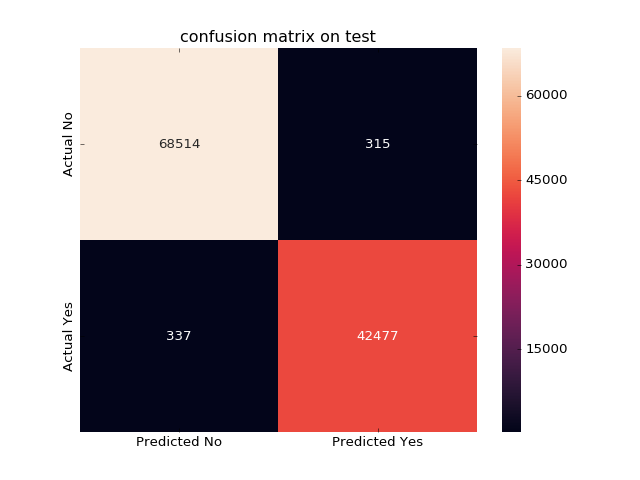

f1 score : 0.992383711422
macro f1 score : 0.993824046298
prediction done...
        actual_Y  predictions
368022         0            0
347889         0            0
6731           1            1
371099         0            0
487726         0            0
270660         1            1
453174         0            0
420316         0            0
334583         0            0
319996         1            1
120196         1            1
150101         0            0
204402         0            0
6665           1            1
210765         1            1
76439          0            0
128651         1            1
119971         1            1
268372         1            1
433588         0            0
287115         1            1
99422          1            1
205597         0            0
212789         1            1
415365         0            0
398477         0            0
432463         1            1
336770         0            0
473996         0            0
433572         0       

In [24]:
model_performance = performance(X,Y)
print(model_performance)